# Reconstruction of DOSY NMR Signals - Part I

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

### 2 Generation of synthetic data

**Question 2**

In [2]:
def construct_T(Tmin, Tmax, N) : 
    t = np.linspace(0, 1, N)
    return Tmin * np.exp(-t * np.log(Tmin/Tmax))

N = 200
Tmin = 1
Tmax = 1000

T = construct_T(Tmin, Tmax, N)

**Question 3**

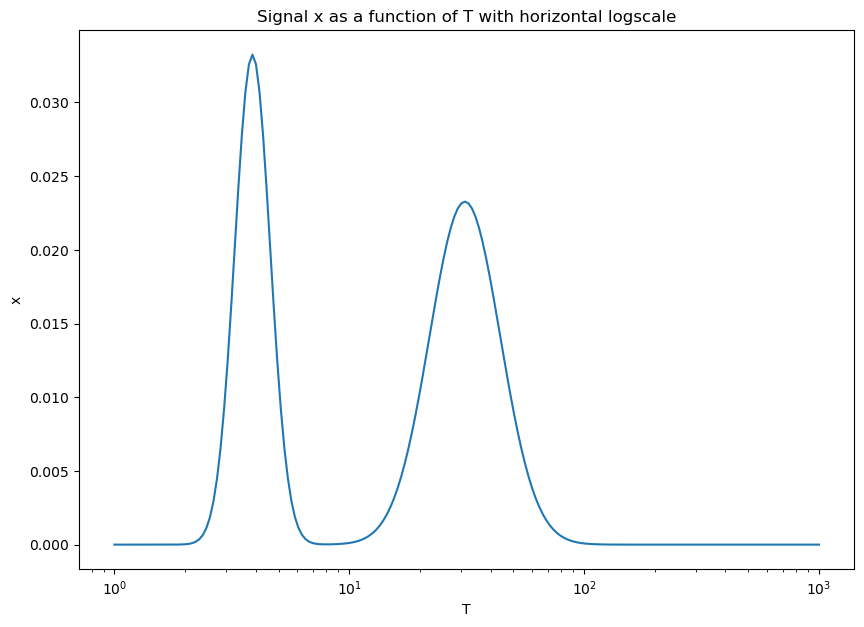

In [3]:
#display the signal with logscale on horizontal axis
from numpy import loadtxt
bar_x = loadtxt('signal.txt')

plt.figure(figsize = (10, 7))
plt.semilogx(T, bar_x)
plt.xlabel('T')
plt.ylabel('x')
plt.title('Signal x as a function of T with horizontal logscale')

plt.show()

**Question 4**

In [4]:
def construct_t(tmin, tmax, M) : 
    t = np.linspace(0, 1, M)
    return tmin + t * (tmax - tmin) 

M = 50
tmin = 0
tmax = 1.5

t = construct_t(tmin, tmax, M)

**Question 5**

In [5]:
def construct_K(T, t) : 
    M = t.shape[0]
    t = t.reshape(M, 1)
    N = T.shape[0]
    T = T.reshape(1, N)
    return np.exp(-t @ T)    

K = construct_K(T, t)

**Question 6**

In [6]:
def noisy_data(x, K) : 
    sigma = 0.01 * (K @ x)[0]
    M = K.shape[0]
    mu = np.zeros(M)
    w = np.random.multivariate_normal(mu, sigma**2 * np.identity(M))
    return K @ x + w

y = noisy_data(bar_x, K)

**Question 7**

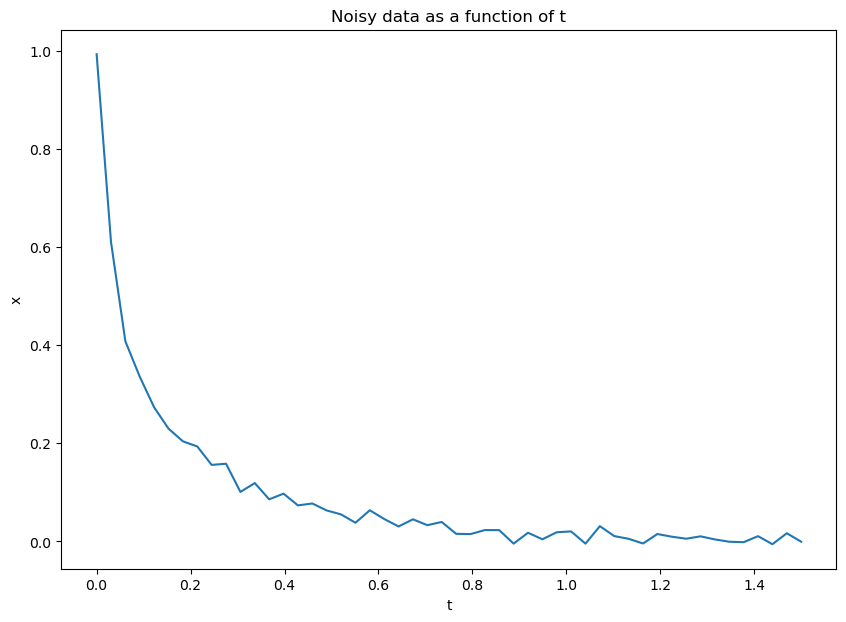

In [7]:
plt.figure(figsize = (10, 7))
plt.title('Noisy data as a function of t')
plt.xlabel('t')
plt.ylabel('x')
plt.plot(t, y)
plt.show()

### 3 Comparison of regularization strategies

**Question 1**

For the smoothness prior + constraints and the $L^1$ norm, there is at least one minimizer. For the smoothness prior + constraints, this is because the set $C$ is bounded, and $h(x) = \frac{1}{2}\lVert Kx - y \rVert ^2 + \frac{\beta}{2} \lVert Dx \rVert^2 \in \Gamma_0(\mathbb{R}^N)$. For the $L^1$ norm, this is true because the function $h$ is coercive. For the $L^1$ norm, the minimizer is unique because $h$ is strictly convex. 

**Question 2**

For the smoothness prior, $g$ is differentiable, so we can solve the problem with gradient descent. 
For the other 2 functions, they are not differentiable, but $f(x) = \frac{1}{2}\lVert Kx-y \rVert^2$ is differentiable, so we can solve the problem with the forward-backward algorithm. We have $\nabla f(x) = K^TKx - Ky$, so $\nabla f$ is $\lVert K^TK\rVert$-lipschitzian (the matrix norm is the spectral norm).

**Question 3**

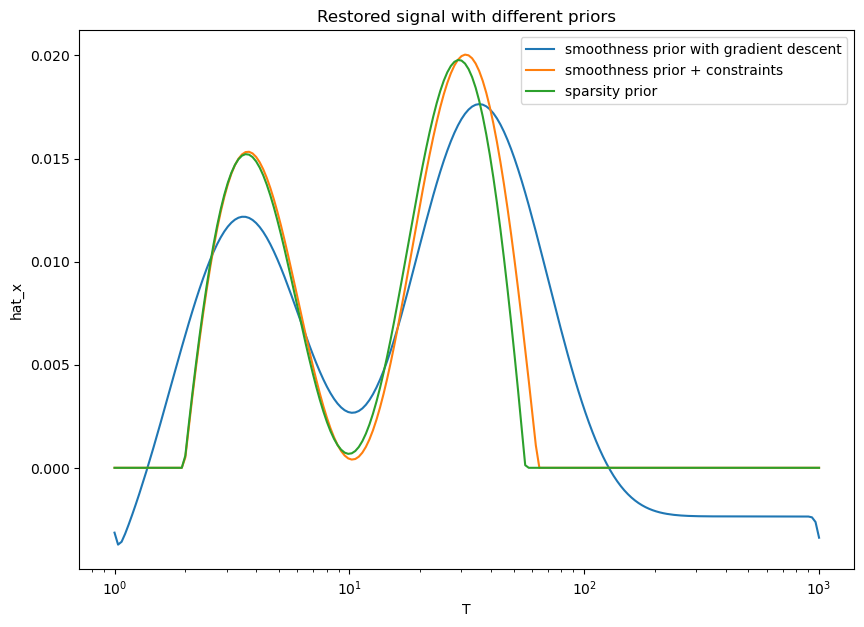

In [8]:
#used for the last g function 
x_min = np.min(bar_x)
x_max = np.max(bar_x)

#regularization parameter, that can be changed
beta = 1

#the discrete gradient matrix 
D = np.identity(N)
for i in range(N-1):
    D[i+1][i] = -1
D[0][-1] = -1


def g1(x):
    '''
    returns the smoothness prior 
    '''
    return (np.linalg.norm(D @ x)**2)/2


def g2(x):
    '''
    returns the smoothness prior + constraints
    '''
    x_min = np.asarray(min)
    x_max = np.asarray(max)
    if np.all((x >= x_min) & (x <= x_max)):
        return np.infty
    return g1(x)


def g3(x):
    '''
    returns the sparsity prior
    '''
    return np.linalg.norm(x, ord=1)


#first implement the gradient descent for the smoothness prior (even though the forward-backward algorithm also 
#solves the problem)

def gradient_descent(x0, nb_steps, eta, beta):
    '''
    performs the gradient descent with a step size eta for nb_steps steps
    '''
    x_n = x0
    for i in range(nb_steps):
        grad = K.T @ (K @ x_n - y) + beta*D.T @ D @ x_n
        x_n -= eta*grad
    return x_n


#implement the forward-backward algorithm, the step size will be taken as 1/nu, where 
#nu is the lipschitz constant of the gradient of f 

def forward_backward(x0, nb_steps, prox, beta):
    x_n = x0
    gamma = 1/(np.linalg.norm(K.T @ K, ord=2))
    for i in range(nb_steps):
        #update y
        grad = K.T @ (K @ x_n - y)
        y_n = x_n - gamma*grad
        #update x
        x_n = prox(y_n, gamma, beta)
    return x_n       


def prox1(y, gamma, beta):
    '''
    proximal operator for the smoothness prior
    '''
    A = np.eye(len(y)) + gamma*beta*D.T @ D
    b = y
    x = np.linalg.solve(A, b)
    return x


def prox2(y, gamma, beta):
    '''
    proximal operator for the smoothness prior + constraints
    '''
    A = np.eye(len(y)) + gamma*beta*D.T @ D
    b = y
    x = np.linalg.solve(A, b)
    return np.minimum(np.maximum(x, x_min), x_max)


def prox3(y, gamma, beta):
    '''
    proximal operator for the sparsity prior
    '''
    return np.sign(y)*np.maximum(np.abs(y)-beta*gamma, 0)

#display the restored signal hat_x with different priors and different betas
x0 = np.zeros(N)
hat_x1 = gradient_descent(x0, 5000, 0.002, 0.05)
#hat_x1 = forward_backward(x0, 5000, prox1, 0.1)
hat_x2 = forward_backward(x0, 5000, prox2, 0.01)
hat_x3 = forward_backward(x0, 5000, prox3, 0.04) 

plt.figure(figsize = (10, 7))
#plt.semilogx(T, hat_x1, label='smoothness prior with forward-backward')
plt.semilogx(T, hat_x1, label='smoothness prior with gradient descent')
plt.semilogx(T, hat_x2, label='smoothness prior + constraints')
plt.semilogx(T, hat_x3, label='sparsity prior')
plt.title('Restored signal with different priors')
plt.xlabel('T')
plt.ylabel('hat_x')
plt.legend()
plt.show()

**Question 4**

In [9]:
def E(bar_x, hat_x):
    return np.linalg.norm(bar_x - hat_x)**2/np.linalg.norm(bar_x)**2
print("For the smooth prior, the normalized quadratic error is :", E(bar_x, hat_x1))
print("For the smooth prior + constraints, the normalized quadratic error is :", E(bar_x, hat_x2))
print("For the sparsity prior, the normalized quadratic error is :", E(bar_x, hat_x3))

For the smooth prior, the normalized quadratic error is : 0.3115732828625603
For the smooth prior + constraints, the normalized quadratic error is : 0.15576633847297042
For the sparsity prior, the normalized quadratic error is : 0.1734550044940404


**Question 5**

For the sparsity prior, as expected, big values of $\beta$ lead to a signal that was too sparse, and $\beta = 0.05$ is approximately the optimal value for a better reconstruction. For the smoothness prior + constraints, bigger values of $\beta$ lead to a function that was too smooth (with decreasing maximum values on the 2 peaks), and the same thing was observed for the smoothness prior, and $\beta = 0.01$ gave the best results in term of normalized quadratic error for the smoothness prior + constraints, and $\beta = 0.04$ for the smoothness prior.  

# Reconstruction of DOSY NMR Signals - Part II

### 1 Maximum entropy regularization

**Question 1**

ent is not differentiable (not continuous even), proper, convex and lower semi-continuous. In fact, $\phi$ is convex and lower semi-continuous (on one coordinate in $\mathbb{R}$) and ent is the sum of convex functions with positive coefficients so convex and lower-semi-continuous too.  

**Question 2**

The optimization problem has a solution because ent $\in \Gamma_0(\mathbb{R}^N)$ and ent is coercive. It is unique because $\phi$ is stricly convex on its domain. 

**Question 3**

The minimizer of $\frac{1}{2}\lVert x - u \rVert^2 + \mu ent(u)$ can only be in $({\mathbb{R}^*}_+)^N$. ent is differentiable on its domain, and the function we are trying to minimize is convex, so the minimizer is given by the zero of the gradient, that is (for every function only defined on $\mathbb{R}$, we will keep the notation on $\mathbb{R}^N$ and considering it is applied coordinate wise): for $u \in Dom(ent)$, $\nabla  (\frac{1}{2}\lVert x - u \rVert^2 + \mu ent(u)) = u - x + \mu(\mathbb{1} + log(u))$, and $1$ is the vector of ones. We then have $$u'exp(u') = \frac{1}{\mu} exp((x - \mu)/\mu)$$ where $u' = -log(u) + x/\mu - 1$, and using the Lambert W function, $u^* = exp(-W\left(exp((x - \mu)/\mu \right) /\mu) + (x - \mu)/\mu)$. 


**Question 4**

For the forward-backward algorithm, ent is not differentiable and $\frac{1}{2} \lVert Kx - y \rVert^2$ is with a $\nu = \lVert K^T K \rVert$-lipschitzian gradient, and they are both in $\Gamma_0(\mathbb{R}^N)$ so the algorithm can be :

$
\forall n \in \mathbb{N}, \quad
\begin{cases}
y_n = x_n - \gamma K^T (Kx_n - y), \\
x_{n+1} = \text{prox}_{\gamma f}(y_n).
\end{cases}
$

with $\gamma = \frac{1}{\nu}$, $f(x) = $ the proximal operator written in the question below with $M = \beta \gamma$. 

For the Douglas-Rashford algorithm, the justification as to why it can be used is the same as before, and the algorithm is ($\gamma$ is the same as before) :

$
\forall n \in \mathbb{N}, \quad
\begin{cases}
y_n = \text{prox}_{\gamma f}(x_n), \\
z_n = \text{prox}_{\gamma g}(2y_n - x_n), \\
x_{n+1} = \frac{1}{2}(z_n - y_n) + x_n
\end{cases}
$

where $\text{prox}_{\gamma g}(x) =$ solution of ($(\gamma K^TK + I)u = x + \gamma K^Ty$). 

**Question 5**

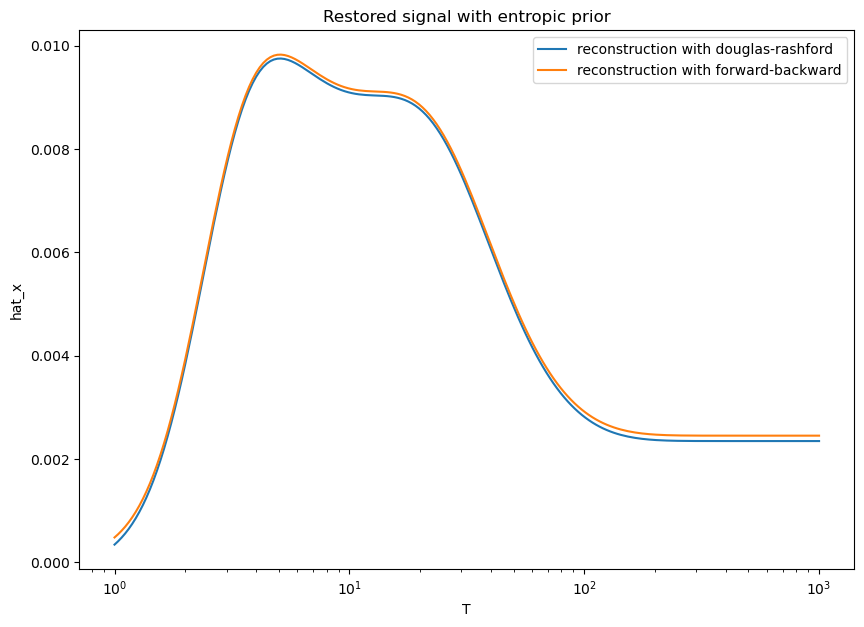

In [10]:
import scipy
import scipy.special 

def prox4(u, gamma, beta):
    '''
    proximal operator for the beta*gamma*ent function 
    '''
    x = np.exp((u-gamma*beta)/(beta*gamma))
    x /= (gamma*beta)
    x = -scipy.special.lambertw(x, 0).real
    x += (u-beta*gamma)/(beta*gamma)
    return np.exp(x)

def prox5(u, gamma, beta):
    '''
    proximal operator for the function gamma*norm(Kx-y)^2
    ''' 
    A = np.eye(len(u)) + gamma*K.T @ K
    b = u + gamma*K.T @ y
    x = np.linalg.solve(A, b)
    return x 


def dr(x0, nb_steps, prox1, prox2, beta, lambd=1):
    x_n = x0
    gamma = 1/(np.linalg.norm(K.T @ K, ord=2))
    for i in range(nb_steps):
        #updates
        y_n = prox1(x_n, gamma, beta)
        z_n = prox2(2*y_n - x_n, gamma, beta)
        x_n = lambd*(z_n - y_n) + x_n
    return x_n


def forward_backward_ent(x0, nb_steps, prox, beta):
    x_n = x0
    gamma = 1/(np.linalg.norm(K.T @ K, ord=2))
    for i in range(nb_steps):
        #update y
        grad = K.T @ (K @ x_n - y)
        y_n = x_n - gamma*grad
        #update x
        x_n = prox(y_n, gamma, beta)
    return x_n

beta = 0.01
x0 = np.ones(N)/N

#display the restored signal hat_x with entropic prior
hat_x4 = dr(x0, 5000, prox4, prox5, beta)
hat_x5 = forward_backward_ent(x0, 5000, prox4, beta)
plt.figure(figsize = (10, 7))
plt.semilogx(T, hat_x4, label='reconstruction with douglas-rashford')
plt.semilogx(T, hat_x5, label='reconstruction with forward-backward')
plt.title('Restored signal with entropic prior')
plt.xlabel('T')
plt.ylabel('hat_x')
plt.legend()
plt.show()

**Question 6**

The best choice of $\beta$ that minimizes the error is : 
$\beta = 0.01$ for the forward-backward algorithm, and $\beta = 0.009$ for the Douglas-Rashford algorithm. 

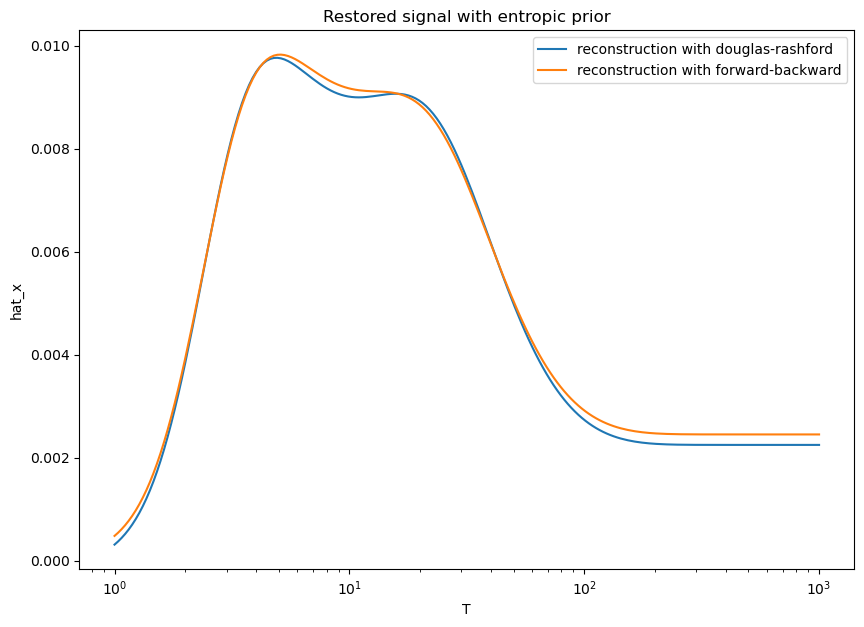

For the DR algo, the normalized quadratic error is : 0.5425425748837904
For the forward-backward algo, the normalized quadratic error is : 0.5530627419813618


In [16]:
beta1 = 0.009
beta2 = 0.01
x0 = np.zeros(N)

#display the restored signal hat_x with entropic prior
hat_x4 = dr(x0, 5000, prox4, prox5, beta1)
hat_x5 = forward_backward_ent(x0, 5000, prox4, beta2)
plt.figure(figsize = (10, 7))
plt.semilogx(T, hat_x4, label='reconstruction with douglas-rashford')
plt.semilogx(T, hat_x5, label='reconstruction with forward-backward')
plt.title('Restored signal with entropic prior')
plt.xlabel('T')
plt.ylabel('hat_x')
plt.legend()
plt.show()

print("For the DR algo, the normalized quadratic error is :", E(bar_x, hat_x4))
print("For the forward-backward algo, the normalized quadratic error is :", E(bar_x, hat_x5))

**Question 7**

The reconstruction with the maximum entropy regularization is worse than for the last 2 priors in term of reconstruction quality. 

**Question 8**

We can try to perform a gradient descent, while trying to maintain $x$ into the constrained set. This means performing a gradient descent step, then projecting the obtained value onto the constrained set. The update may be written : 

$
\forall n \in \mathbb{N}, \quad
\begin{cases}
y_n = x_n - \mu K^T (Kx_n - y), \\
x_{n+1} = \text{proj}_C(y_n).
\end{cases}
$

where $C = \{x \ | \ \lVert Kx - y \rVert^2 \leq \eta M \sigma^2\}$, and $\mu$ is the step size. 


Converged in 234 iterations.


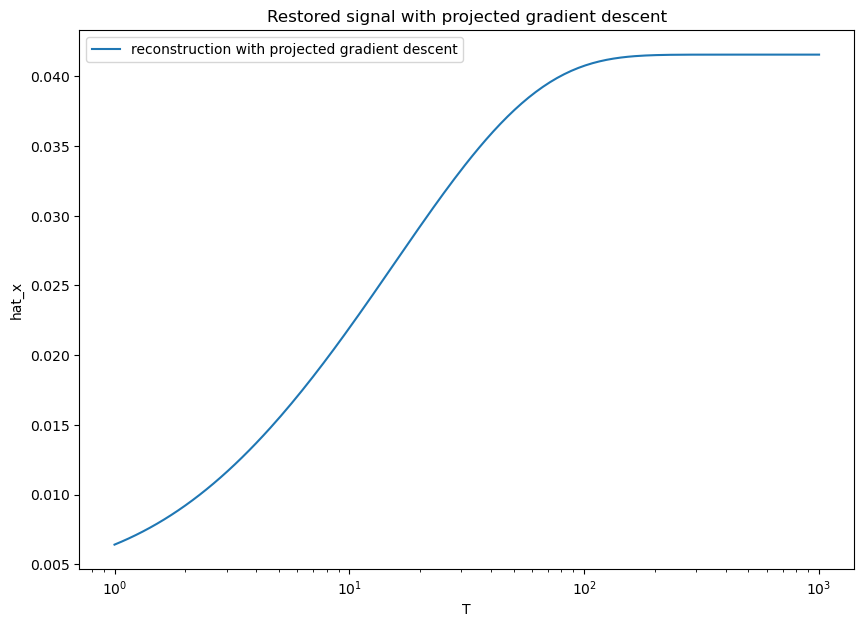

In [12]:
import cvxpy as cp

def project(x, K, y, epsilon):
    '''
    returns the projection of x onto the ellipsoid 
    C = {x | ||Kx-y||_2 <= epsilon}
    '''
    #variable
    z = cp.Variable(x.shape)

    #objective
    objective = cp.Minimize(cp.norm(z - x, 2))

    #constraint
    constraint = [cp.norm(K @ z - y, 2) <= epsilon]

    #optimize
    problem = cp.Problem(objective, constraint)
    problem.solve(solver=cp.SCS, verbose=False)
    return z.value


def projected_gradient_descent(x0, eta_M_sigma2, nb_steps, tol=1e-6, step_size=1e-3):
    x_n = x0 
    for i in range(nb_steps):
        # gradient descent step
        x = x_n.copy() 
        grad = 1 + np.log(x_n)
        x_n -= step_size * grad
        
        # Project onto the feasible set
        x_n = project(x_n, K, y, eta_M_sigma2)
        
        # stop early eventually
        if np.linalg.norm(x_n - x) < tol:
            print(f"Converged in {i} iterations.")
            break    
    return x_n

M = 50
eta = 0.1
sigma2 = 1
x0 = np.ones(N)/N

hat_x6 = projected_gradient_descent(x0, eta*M*sigma2, 5000)
plt.figure(figsize = (10, 7))
plt.semilogx(T, hat_x6, label='reconstruction with projected gradient descent')
plt.title('Restored signal with projected gradient descent')
plt.xlabel('T')
plt.ylabel('hat_x')
plt.legend()
plt.show()